## **ANALYTICAL EXPLANATIONS OF EACH CHART IS PRESENT IN SUBSEQUENT FILES ON THE REPOSITORY**

#### **DATA BASIC CLEANUP AND ADDITION PROCEDURE (SENDING THIS TO SQL)**

In [ ]:
import pandas as pd    #pandas for filtering and analysis
import mysql.connector #used for connecting and interacting with mysql

df = pd.read_csv("apple.csv")  
#loaded the cleaned .csv file into this dataframe (pandas)


df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y") 
#converting the date column from string to datetime format

#if any value is missing, we replace it as None so mysql stores it as null
df['Open'] = df['Open'].where(pd.notna(df['Open']), None)
df['Low'] = df['Low'].where(pd.notna(df['Low']), None)
df['Volume'] = df['Volume'].where(pd.notna(df['Volume']), None)
df['High'] = df['High'].where(pd.notna(df['High']), None)
df['Close'] = df['Close'].where(pd.notna(df['Close']), None)
df['Adjusted Close'] = df['Adjusted Close'].where(pd.notna(df['Adjusted Close']), None)
#establishing connection to mysql datbase, the credentials should match your setup
conn = mysql.connector.connect(
    host="localhost",                       #mysql host name here
    user="XXXX",                            #mysql username here
    password="XXXX",             #mysql password here
    database="apple-stock-price-prediction" #add the database name here   
)
#tool that helps you run SQL commands in this database
cursor = conn.cursor()

#used a for-loop to loop through each row of this dataframe
for _, row in df.iterrows():
    values = (                      
        row['Date'].strftime("%Y-%m-%d"), #for the date column (converted)
        row['Low'],                       #low price (int)
        row['Open'],                      #open price(int)
        row['Volume'],                    #volume (int)
        row['High'],                      #high price (int)
        row['Close'],                     #closing price (int)
        row['Adjusted Close']             #adjusted closing price (int)
    )

    #MYSQL command to insert values into the performance data table
    cursor.execute("""
        INSERT INTO stock_price_info (
            date, low, open,
            volume, high,
            close, adjusted_closing
        ) VALUES (%s, %s, %s, %s, %s, %s, %s)
    """, values)   

conn.commit() #save the changes to database 
cursor.close()
conn.close()
#close the server and database connections

#### **IMPORTING PACKAGES NECESSARY**

In [109]:
import pandas as pd                                  #for data reading
from scipy import stats as st                        #for statistical operations
import numpy as np                                   #for mathematical ease
import matplotlib.pyplot as plt                      #for plotting
import statsmodels as sm                             #for statistical information
import seaborn as sns                                #for chart libraries
from sklearn.linear_model import LinearRegression    #for regression
from sklearn.model_selection import train_test_split #for training model
from sklearn.metrics import mean_squared_error       #for MSE

#### **Mean, Median and Mode Closing Prices**

In [110]:
df = pd.read_csv("apple.csv", parse_dates=['Date'], dayfirst=True)   # loading my dataset
# dayfirst=True to avoid errors and problems

# Computing mean, median and standard deviation of closing price of stock
mean_close = round(df['Close'].mean(),3)                          # mean
median_close = round(df['Close'].median(),3)                      # median
mode_close = round(st.mode(df['Close'], keepdims=True).mode[0],3) # mode

print("For years 2020-2022-")
print("Mean Close:", mean_close) 
print("Median Close:", median_close)
print("Mode Close:", mode_close)

For years 2020-2022-
Mean Close: 44.967
Median Close: 30.655
Mode Close: 17.167


### **CLOSING PRICE ON FINAL TRADING DAY**

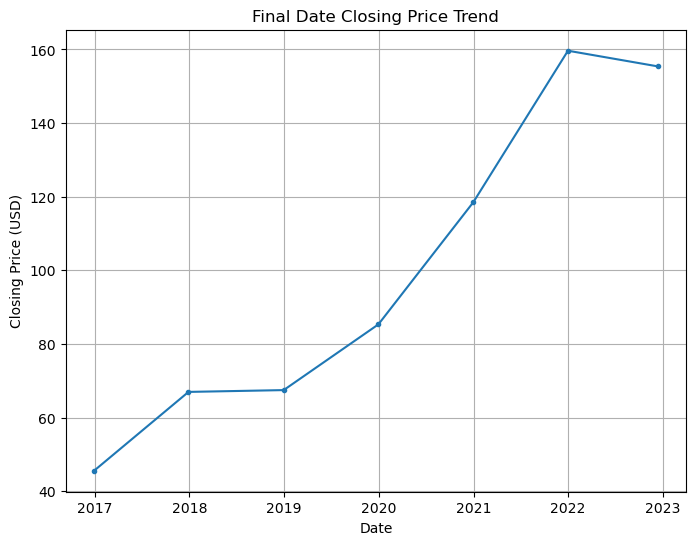

In [ ]:
#'dayfirst=True' used to suppress warning, no harm done to the dataframe
df['Year'] = df['Date'].dt.year               # extracting the year from each date

final_days = df.groupby('Year')['Date'].max() # getting the final trading day by using max() function
final_data = df[df['Date'].isin(final_days)]  # just getting the final trading day of the year

filtered = final_data[final_data['Year'] >= 2016]
# filtering to only gather data for years 2016 to 2023

plt.figure(figsize=(8,6))                                  # deciding size of graph
plt.plot(filtered['Date'], filtered['Close'],marker = '.') # plotting information
plt.title('Closing Price Trend')                           # addng a title to the plot
plt.xlabel('Date')                                         # naming the x-axis
plt.ylabel('Closing Price (USD)')                          # naming the y-axis
plt.grid(True)                                             # adding grid to better understand the graph
plt.show()                                                 #shows the graph


### **PLOTTING YEARLY AVERAGE CLOSING PRICE**

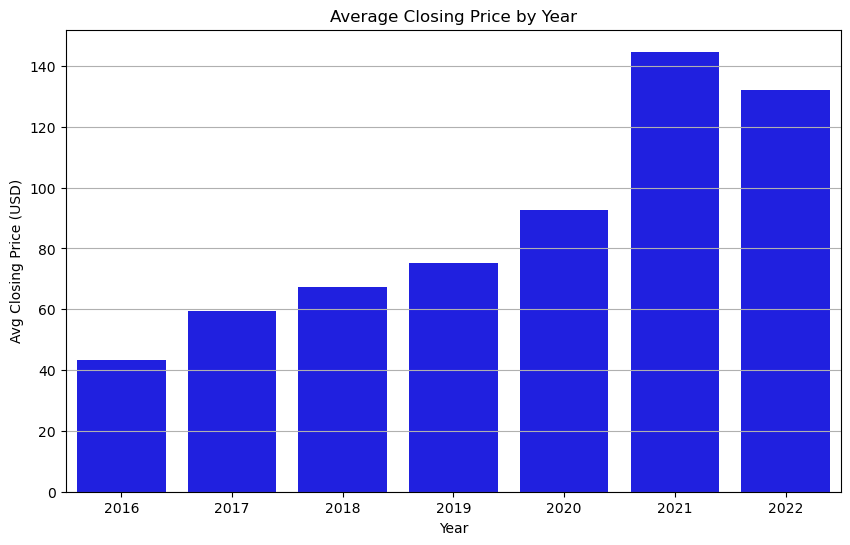

In [113]:
df['Date'] = pd.to_datetime(df['Date']) # converting to datetime format
df['Year'] = df['Date'].dt.year         # extracting years only

df_filtered = df[df['Year'] >= 2016]    # filtering to get only beyond 2016

plt.figure(figsize=(10,6))              # plot size decided

'''
why did we call plt.figure() before sns.barplot()?
sns.barplot, by default, creates its own plot on the current figure. By using plt.figure() before sns.barplot(), 
we create and set the figure where sns.barplot() draws its chart.
-----
If plt.figure() is called after sns.barplot(), it creates a new blank figure, resulting in two charts: 
the actual seaborn plot and an empty figure.

'''
# function for barchart, deciding x-axis, y-axis, data to be used, the colour, errorbars and other information
sns.barplot(x='Year', y='Close', data=df_filtered, errorbar= None, color='blue')

plt.title('Average Closing Price by Year') # adding a title
plt.xlabel('Year')                         # naming x-axis
plt.ylabel('Avg Closing Price (USD)')      # naming y-axis
plt.grid(axis='y')                         # adding horizontal grids to better understand
plt.show()                                 # shows the graph

### **DISTRIBUTION CHART OF DAILY RETURNS**

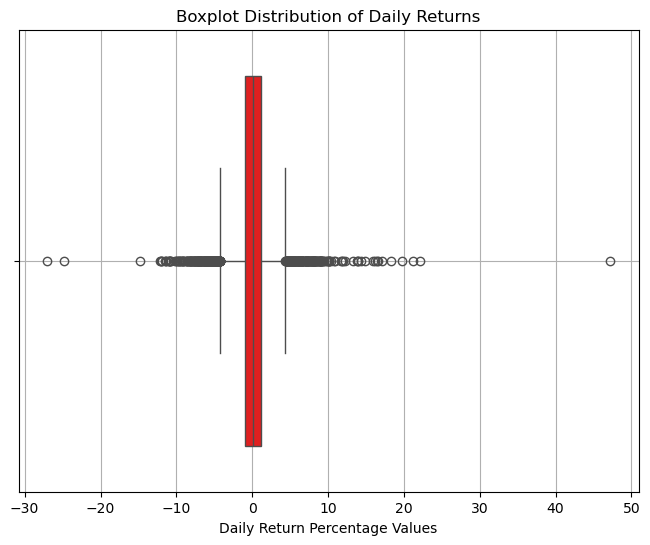

In [ ]:
df = df.sort_values('Date')

# Compute daily returns as percentage change in 'Close' price
df['Daily_Return'] = df['Close'].pct_change() * 100  # multiply by 100 for percentage returns

returns = df['Daily_Return'].dropna()             # Drops nil values created by pct_change()

plt.figure(figsize=(8,6))                         # figsize decided

# function for boxplot using returns data after dropping NA values
sns.boxplot(x = returns,color= 'red')

plt.title('Boxplot Distribution of Daily Returns') # adding a title
plt.xlabel('Daily Return Percentage Values')       # naming x-axis
plt.grid(True)                                     # adds grid for better understanding
plt.show()                                         # shows the graph

#### **BAR CHART SHOWING VOLATILITY BY YEAR (USING % CHANGE IN DAILY RETURNS)**

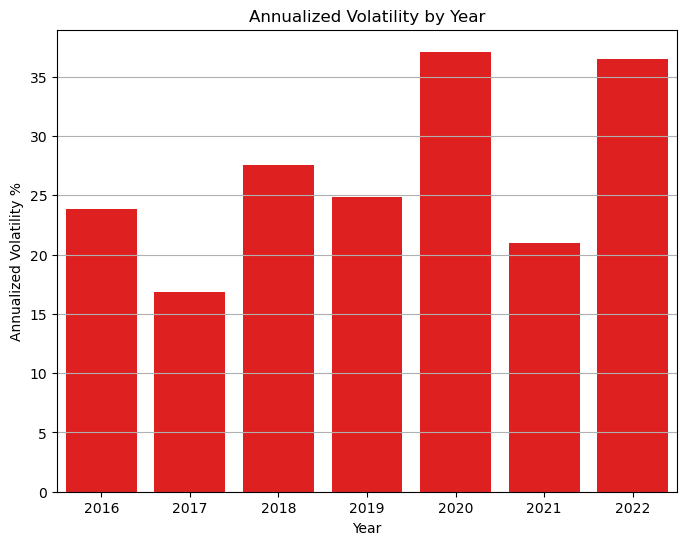

In [ ]:
# usual procedure to perform when solving most of the questions
# conversion of dates to datetime and sorting dates in ascending order
df = df.sort_values('Date')

df['Daily_Return'] = df['Close'].pct_change() # finding the percentage change in closing price wrt daily return
df['Year'] = df['Date'].dt.year               # extracting year from dates
df_filtered = df[df['Year'] >= 2016]          # filtering to only get dates beyond 2016

std_dev_by_year = df_filtered.groupby('Year')['Daily_Return'].std() 
# we can also choose to calculate 'variance'[.var()], but std_dev is preferrrable. (detailed explanation in text document)
volatility_by_year = std_dev_by_year * np.sqrt(260)
'''
first, we grouped daily returns by years 
for each group, we found how far apart the daily returns are from the average -
[i.e. by using std() to calculate standard deviation]
why 260? 
4 weeks in a month, 8 days off in a month, 96 days off in an year
Including vacation, number of trading days in an year boils down to 260 rounded off
why sqrt?
volatility moves in different directions over time, sometimes they cancel each other out. 
we can choose to multiply it without the sqrt, but it's going to overestimate the volatility.
'''
x = volatility_by_year
y = volatility_by_year
plt.figure(figsize=(8,6))                  # determining size of graph
sns.barplot(x= x.index, y= y.values*100, color='red') # plotting bar chart
plt.title('Annualized Volatility by Year') # ading title
plt.xlabel('Year')                         # naming x-axis
plt.ylabel('Annualized Volatility %')      # naming y-axis
plt.grid(axis='y')                         # adding horizontal grids to better understand the trends  
plt.show()                                 # prints the graph

#### **IDENTIFYING GOLDEN CROSS AND DEATH CROSS USING 50/200-DAY MOVING AVERAGES**

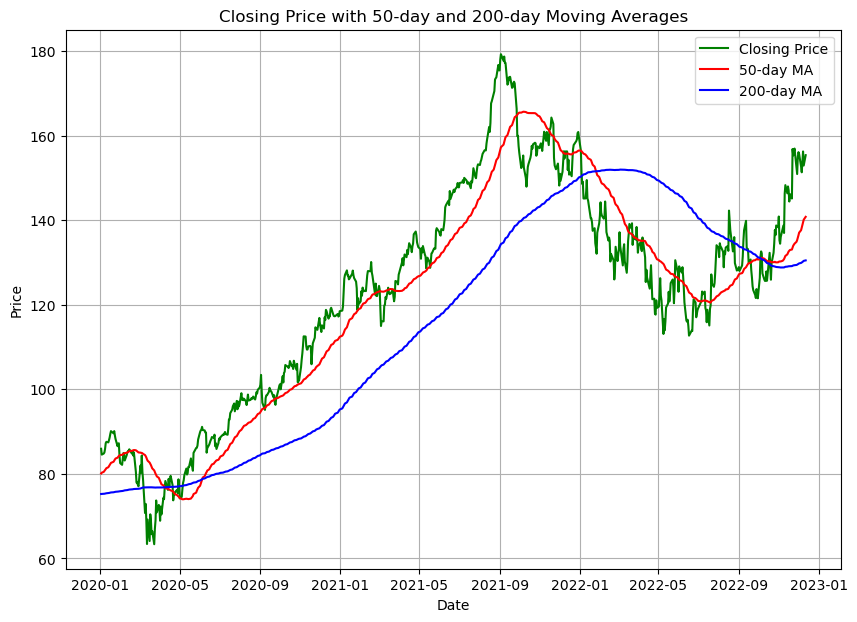

'\nGolden Cross means when the 50-day moving average exceeds the 200-day moving average.\nDeath Cross event means when the 50-day moving average crosses below the 200-day moving average\nGolden cross = shifting upwards, positive reaction, prices likely rising\nDeath cross = shifting downwards, caution required, prices likely falling\n'

In [116]:
df['Mov-Avg-50'] = df['Close'].rolling(window=50).mean()
# creates a 50-day moving average - rolling()
df['Mov-Avg-200'] = df['Close'].rolling(window=200).mean()
# creates a 200-day moving average

specific_filter = (df['Date'].dt.year >= 2020) 
# filtering out to get above 2020
df_filtered = df.loc[specific_filter]
# returns subset of dataframe with my condition

plt.figure(figsize=(10,7))
plt.plot(df_filtered['Date'], df_filtered['Close'], label='Closing Price', color='green')
# plotting graph for closing price

plt.plot(df_filtered['Date'], df_filtered['Mov-Avg-50'], label='50-day MA', color='red')
# plotting graph for 50-day MA

plt.plot(df_filtered['Date'], df_filtered['Mov-Avg-200'], label='200-day MA', color='blue')
# plotting graph for 200-day MA

plt.title('Closing Price with 50-day and 200-day Moving Averages') # title
plt.xlabel('Date')         # naming x-axis
plt.ylabel('Price')        # naming y-axis
plt.legend()               # adding a legend
plt.grid(True)             # adding grids for better visualisation
plt.show()                 # shows the graph

'''
Golden Cross means when the 50-day moving average exceeds the 200-day moving average.
Death Cross event means when the 50-day moving average crosses below the 200-day moving average
Golden cross = shifting upwards, positive reaction, prices likely rising
Death cross = shifting downwards, caution required, prices likely falling
'''

#### **RELATIVE STRENGTH INDEX**

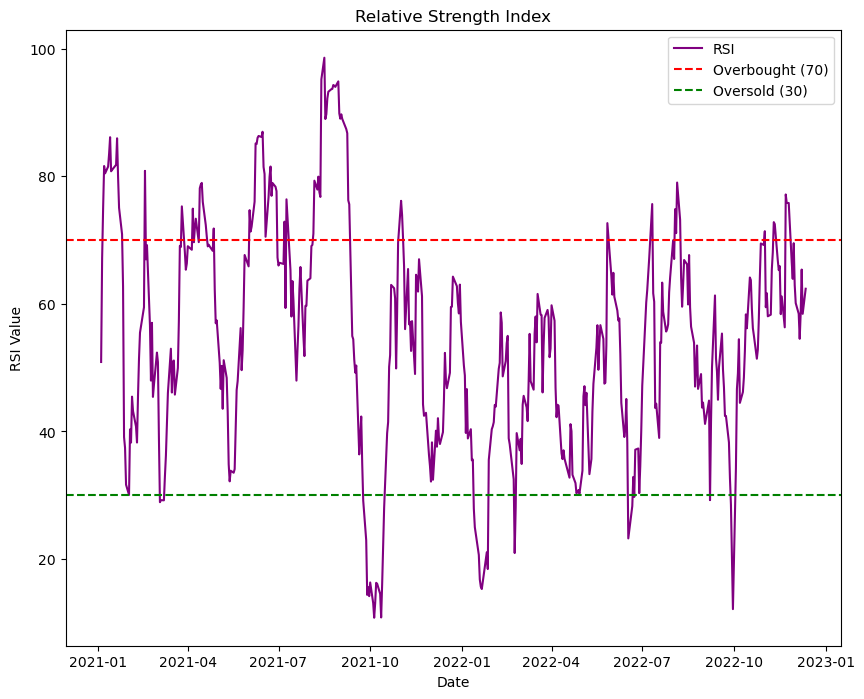

In [119]:
# calculate difference in daily closing prices
delta = df['Close'].diff()

# calculate average gains and losses over 14 days
gain = delta.clip(lower=0).rolling(14).mean()
loss = -delta.clip(upper=0).rolling(14).mean()
# .clip(lower) replaces all negative values with 0
# .clip(upper) replaces all positive values with 0

# calculate Relative Strength and Relative Strength Index
rs = gain / loss
# above is the formula for basic Relative Strength
df['RSI'] = 100 - (100 / (1 + rs)) 
# above is the formula for RSI

# filter data to extract post 2020
filtered_df = df[df['Date'] > '2020-12-31']

plt.figure(figsize = (10,8)) # figure size

plt.plot(filtered_df['Date'], filtered_df['RSI'], label='RSI', color='purple')
# using the filtered out date and RSI for those dates, and plotting it 

plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
# RSI at 70 is marked red, signalling overbuying
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
# RSI at 30 is marked green, signalling overselling

plt.title('Relative Strength Index') # title of chart
plt.xlabel('Date')                   # naming x-axis
plt.ylabel('RSI Value')              # naming y-axis
plt.legend()                         # adding a legend
plt.show()                           # shows the chart
